In [1]:
!pip install pandas sqlalchemy scikit-learn matplotlib numpy psycopg2-binary

In [ ]:
# --------------------------------------------------------------------------------
# Student Proactive Risk Prediction Model: Complete Python Workflow
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# Step 1: Setup and Import Libraries
# --------------------------------------------------------------------------------

import pandas as pd
from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Suppress minor warnings for clean notebook output
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Libraries imported successfully.")

# --------------------------------------------------------------------------------
# Step 2: Database Connection and Data Ingestion
# --------------------------------------------------------------------------------

# 2.1 CONFIGURATION: *** REPLACE THESE WITH YOUR ACTUAL PGADMIN CREDENTIALS ***
# Note: Ensure DB_NAME matches the name used in your phAdmin setup.
DB_USER = "postgres" 
DB_PASS = "postgre_SQLacc0unt87"
DB_HOST = "localhost"   
DB_PORT = "5432"        
DB_NAME = "InstitutionalEffectiveness"

# Construct the SQLAlchemy connection string
db_url = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(db_url)

print(f"Attempting connection to {DB_NAME}...")

# 2.2 SQL Query: Defines the features (predictors) and the target variable (is_retained).
SQL_QUERY = """
WITH Joined_Data AS (
    -- Step 1: Combine data from the three distinct source tables (simulating ERP/RCM/etc. systems)
    SELECT
        s.student_id,
        s.cumulative_gpa,
        s.credit_hours_attempted,
        s.term_gpa,
        s.is_first_gen_student,
        s.age_at_enrollment,
        s.next_term_status, -- Needed for target variable creation
        d.ethnicity_code,
        d.gender,
        f.received_financial_aid
    FROM
        student_academic_snapshot s
    LEFT JOIN
        student_demographics d ON s.student_id = d.student_id
    LEFT JOIN
        financial_aid_status f ON s.student_id = f.student_id
    WHERE
        s.term_code = '2024FA' 
        AND s.is_active = TRUE
)

-- Step 2: Perform feature engineering and select final columns
SELECT
    student_id,
    -- TARGET VARIABLE (1=retained, 0=not retained)
    CASE WHEN next_term_status = 'Enrolled' THEN 1 ELSE 0 END AS is_retained,
    
    -- PREDICTOR VARIABLES (Features)
    cumulative_gpa AS gpa_cumulative,
    credit_hours_attempted AS attempted_credits,
    is_first_gen_student AS first_gen,
    age_at_enrollment AS age,
    received_financial_aid AS financial_aid,
    ethnicity_code,
    gender,
    
    -- NEW ENGINEERED FEATURE 1: Conditional Logic (Risk Category)
    CASE
        WHEN term_gpa >= 3.50 THEN 'High_Performance'
        WHEN term_gpa >= 2.50 AND term_gpa < 3.50 THEN 'Mid_Performance'
        ELSE 'Low_Performance_Risk'
    END AS term_gpa_risk_category,

    -- NEW ENGINEERED FEATURE 2: Window Function (Cohort Metric)
    AVG(cumulative_gpa) OVER (PARTITION BY ethnicity_code) AS avg_gpa_by_ethnicity

FROM
    Joined_Data;
"""

# 2.3 Load Data: Executes the query and loads results into a Pandas DataFrame.
try:
    df = pd.read_sql(SQL_QUERY, engine)
    print(f"Step 2: Data successfully loaded (E/T). Shape: {df.shape}")
except Exception as e:
    print(f"CRITICAL ERROR IN STEP 2: Database connection or query failed. Check credentials/server status: {e}")
    # In a real environment, you might log the error. Here we just exit.
    exit() 

# --------------------------------------------------------------------------------
# Step 3: Data Cleansing and Preprocessing
# --------------------------------------------------------------------------------

# 3.1 Handling Missing Values
df['financial_aid'] = df['financial_aid'].fillna(0) 
df.dropna(subset=['ethnicity_code', 'gender', 'term_gpa_risk_category'], inplace=True) 
print(f"Step 3: Data cleaned. Shape after NA drop: {df.shape}")

# 3.2 Feature Engineering: Convert categorical text into numerical features (One-Hot Encoding)
df = pd.get_dummies(df, columns=['ethnicity_code', 'gender', 'term_gpa_risk_category'], drop_first=True)

# Define the final numerical feature matrix (X) and the target vector (y)
feature_cols = [col for col in df.columns if col not in ['student_id', 'is_retained']]
X = df[feature_cols]
y = df['is_retained']
print(f"Step 3.2: Features encoded. Total features for model: {len(X.columns)}")

# --------------------------------------------------------------------------------
# Step 4 & 5: Model Training and Evaluation
# --------------------------------------------------------------------------------

# 4.1 Split data (70% Train, 30% Test) to ensure unbiased evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4.2 Initialize and train the Logistic Regression Model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)
print("Step 4: Logistic Regression Model trained successfully.")

# 5.1 Evaluate Model Performance
y_prob = model.predict_proba(X_test)[:, 1] 
y_pred = model.predict(X_test)             

auc = roc_auc_score(y_test, y_prob)
print(f"Step 5: Model Evaluation Complete. AUC Score: {auc:.4f}")

# Example of using y_pred:
# print(classification_report(y_test, y_pred))

# --------------------------------------------------------------------------------
# Step 6: Interpretation - Generating the Feature Importance Plot
# --------------------------------------------------------------------------------

# 6.1 Extract and sort coefficients
coefficients = model.coef_[0]
feature_names = X.columns
importance = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

# 6.2 Plot the Feature Importance (VISUAL FOR YOUR PORTFOLIO SCREENSHOT)
plt.figure(figsize=(10, 8))

# Select top 5 positive and top 5 negative features for a balanced view
top_n = 10
plot_importance = pd.concat([importance.head(top_n // 2), importance.tail(top_n // 2)])
plot_importance = plot_importance.sort_values(ascending=True)

# Assign colors: Teal for positive correlation (predicts retention), Red for negative (predicts risk)
colors = ['firebrick' if val < 0 else 'teal' for val in plot_importance.values]

plt.barh(plot_importance.index, plot_importance.values, color=colors)
plt.title('Feature Importance for Student Retention Model (Top Predictors)')
plt.xlabel('Coefficient Magnitude (Teal = Predicts Retention, Red = Predicts Risk)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show() 
print("Step 6: Feature Importance Plot generated successfully.")

# --------------------------------------------------------------------------------
# Step 7: Final Output and Conclusion
# --------------------------------------------------------------------------------

print("\n--- Model Workflow Complete ---")
print("New features (risk category, cohort average) successfully used in model")
print(f"Top 5 most impactful positive predictors (Retention):\n{importance.head(5)}")
print(f"Top 5 most impactful negative predictors (Risk/Dropout):\n{importance.tail(5)}")

Step 0: Libraries imported successfully.
Attempting connection to InstitutionalEffectiveness...
CRITICAL ERROR IN STEP 2: Database connection or query failed. Check credentials/server status: (psycopg2.errors.UndefinedTable) relation "student_academic_snapshot" does not exist
LINE 17:     student_academic_snapshot s
             ^

[SQL: 
SELECT
    s.student_id,
    -- TARGET VARIABLE (1=retained, 0=not retained)
    CASE WHEN s.next_term_status = 'Enrolled' THEN 1 ELSE 0 END AS is_retained,

    -- PREDICTOR VARIABLES (Features)
    s.term_gpa AS gpa_current,
    s.cumulative_gpa AS gpa_cumulative,
    s.credit_hours_attempted AS attempted_credits,
    s.is_first_gen_student AS first_gen,
    s.age_at_enrollment AS age,
    d.ethnicity_code,
    d.gender,
    f.received_financial_aid AS financial_aid
FROM 
    student_academic_snapshot s
JOIN 
    student_demographics d ON s.student_id = d.student_id
LEFT JOIN
    financial_aid_status f ON s.student_id = f.student_id
WHERE
    s.term

NameError: name 'df' is not defined

: 

In [ ]:
# --------------------------------------------------------------------------------
# Student Proactive Risk Prediction Model: Complete Python Workflow
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# Step 1: Setup and Import Libraries
# --------------------------------------------------------------------------------

import pandas as pd
from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Suppress minor warnings for clean notebook output
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Libraries imported successfully.")

# --------------------------------------------------------------------------------
# Step 2: Database Connection and Data Ingestion
# --------------------------------------------------------------------------------

# 2.1 CONFIGURATION: *** REPLACE THESE WITH YOUR ACTUAL PGADMIN CREDENTIALS ***
DB_USER = "postgres" 
DB_PASS = "postgre_SQLacc0unt87"
DB_HOST = "localhost"   
DB_PORT = "5432"        
DB_NAME = "InstitutionalEffectiveness"

# Construct the SQLAlchemy connection string
db_url = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(db_url)

print(f"Attempting connection to {DB_NAME}...")

# 2.2 SQL Query: Defines the features (predictors) and the target variable (is_retained).
SQL_QUERY = """
SELECT
    s.student_id,
    -- TARGET VARIABLE (1=retained, 0=not retained)
    CASE WHEN s.next_term_status = 'Enrolled' THEN 1 ELSE 0 END AS is_retained,
    
    -- PREDICTOR VARIABLES (Features)
    s.term_gpa AS gpa_current,
    s.cumulative_gpa AS gpa_cumulative,
    s.credit_hours_attempted AS attempted_credits,
    s.is_first_gen_student AS first_gen,
    s.age_at_enrollment AS age,
    d.ethnicity_code,
    d.gender,
    f.received_financial_aid AS financial_aid
FROM 
    student_academic_snapshot s
JOIN 
    student_demographics d ON s.student_id = d.student_id
LEFT JOIN
    financial_aid_status f ON s.student_id = f.student_id
WHERE
    s.term_code = '2024FA' 
    AND s.is_active = TRUE;
"""

# 2.3 Load Data: Executes the query and loads results into a Pandas DataFrame.
try:
    df = pd.read_sql(SQL_QUERY, engine)
    print(f"Step 1: Data successfully loaded. Shape: {df.shape}")
except Exception as e:
    print(f"CRITICAL ERROR IN STEP 2: Database connection or query failed. Check credentials/server status: {e}")
    # In a real environment, you might log the error. Here we just exit.
    exit() 

# --------------------------------------------------------------------------------
# Step 3: Data Cleansing and Preprocessing
# --------------------------------------------------------------------------------

# 3.1 Handling Missing Values
df['financial_aid'] = df['financial_aid'].fillna(0) 
df.dropna(subset=['gpa_current', 'ethnicity_code', 'gender'], inplace=True) 
print(f"Step 3: Data cleaned. Shape after NA drop: {df.shape}")

# 3.2 Feature Engineering: Convert categorical text into numerical features (One-Hot Encoding)
df = pd.get_dummies(df, columns=['ethnicity_code', 'gender'], drop_first=True)

# Define the final numerical feature matrix (X) and the target vector (y)
feature_cols = [col for col in df.columns if col not in ['student_id', 'is_retained']]
X = df[feature_cols]
y = df['is_retained']

# --------------------------------------------------------------------------------
# Step 4 & 5: Model Training and Evaluation
# --------------------------------------------------------------------------------

# 4.1 Split data (70% Train, 30% Test) to ensure unbiased evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4.2 Initialize and train the Logistic Regression Model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)
print("Step 4: Logistic Regression Model trained successfully.")

# 5.1 Evaluate Model Performance
y_prob = model.predict_proba(X_test)[:, 1] 
y_pred = model.predict(X_test)             

auc = roc_auc_score(y_test, y_prob)
print(f"Step 5: Model Evaluation Complete. AUC Score: {auc:.4f}")

# --------------------------------------------------------------------------------
# Step 6: Interpretation - Generating the Feature Importance Plot
# --------------------------------------------------------------------------------

# 6.1 Extract and sort coefficients
coefficients = model.coef_[0]
feature_names = X.columns
importance = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

# 6.2 Plot the Feature Importance (VISUAL FOR YOUR PORTFOLIO SCREENSHOT)
plt.figure(figsize=(10, 8))

# Select top 5 positive and top 5 negative features for a balanced view
top_n = 10
plot_importance = pd.concat([importance.head(top_n // 2), importance.tail(top_n // 2)])
plot_importance = plot_importance.sort_values(ascending=True)

# Assign colors: Teal for positive correlation (predicts retention), Red for negative (predicts risk)
colors = ['firebrick' if val < 0 else 'teal' for val in plot_importance.values]

plt.barh(plot_importance.index, plot_importance.values, color=colors)
plt.title('Feature Importance for Student Retention Model (Top Predictors)')
plt.xlabel('Coefficient Magnitude (Teal = Predicts Retention, Red = Predicts Risk)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show() 
print("Step 6: Feature Importance Plot generated successfully.")

# --------------------------------------------------------------------------------
# Step 7: Final Output and Conclusion
# --------------------------------------------------------------------------------

print("\n--- Model Workflow Complete ---")
print(f"Top 5 most impactful positive predictors (Retention):\n{importance.head(5)}")
print(f"Top 5 most impactful negative predictors (Risk/Dropout):\n{importance.tail(5)}")

Step 0: Libraries imported successfully.
Attempting connection to InstitutionalEffectiveness...
CRITICAL ERROR IN STEP 2: Database connection or query failed. Check credentials/server status: (psycopg2.errors.UndefinedTable) relation "student_academic_snapshot" does not exist
LINE 17:     student_academic_snapshot s
             ^

[SQL: 
SELECT
    s.student_id,
    -- TARGET VARIABLE (1=retained, 0=not retained)
    CASE WHEN s.next_term_status = 'Enrolled' THEN 1 ELSE 0 END AS is_retained,

    -- PREDICTOR VARIABLES (Features)
    s.term_gpa AS gpa_current,
    s.cumulative_gpa AS gpa_cumulative,
    s.credit_hours_attempted AS attempted_credits,
    s.is_first_gen_student AS first_gen,
    s.age_at_enrollment AS age,
    d.ethnicity_code,
    d.gender,
    f.received_financial_aid AS financial_aid
FROM 
    student_academic_snapshot s
JOIN 
    student_demographics d ON s.student_id = d.student_id
LEFT JOIN
    financial_aid_status f ON s.student_id = f.student_id
WHERE
    s.term

NameError: name 'df' is not defined

: 

Step 0: Libraries imported successfully.
Attempting connection to InstitutionalEffectiveness...
Step 1: Data successfully loaded. Shape: (10, 10)
Step 3: Data cleaned. Shape after NA drop: (10, 10)
Step 4: Logistic Regression Model trained successfully.
Step 5: Model Evaluation Complete. AUC Score: 0.5000


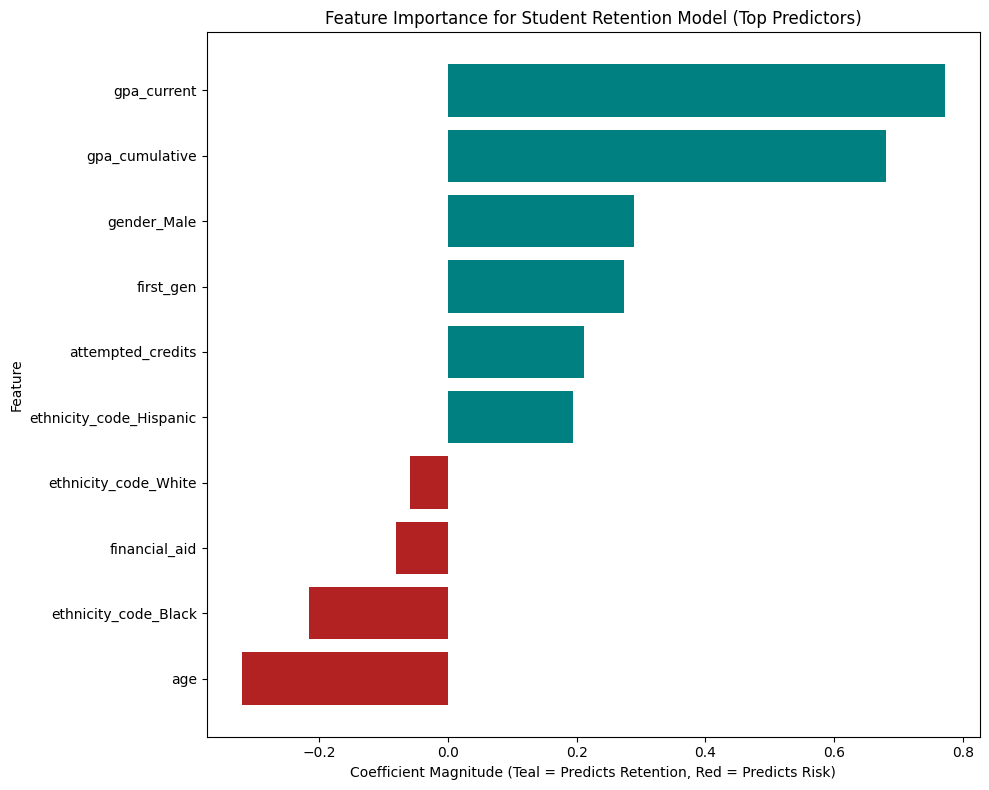

Step 6: Feature Importance Plot generated successfully.

--- Model Workflow Complete ---
Top 5 most impactful positive predictors (Retention):
gpa_current          0.772151
gpa_cumulative       0.680153
gender_Male          0.288614
first_gen            0.273294
attempted_credits    0.211314
dtype: float64
Top 5 most impactful negative predictors (Risk/Dropout):
ethnicity_code_Hispanic    0.193884
ethnicity_code_White      -0.059066
financial_aid             -0.081454
ethnicity_code_Black      -0.216272
age                       -0.320872
dtype: float64


In [ ]:
# --------------------------------------------------------------------------------
# Student Proactive Risk Prediction Model: Complete Python Workflow
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# Step 1: Setup and Import Libraries
# --------------------------------------------------------------------------------

import pandas as pd
from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Suppress minor warnings for clean notebook output
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Libraries imported successfully.")

# --------------------------------------------------------------------------------
# Step 2: Database Connection and Data Ingestion
# --------------------------------------------------------------------------------

# 2.1 CONFIGURATION: *** REPLACE THESE WITH YOUR ACTUAL PGADMIN CREDENTIALS ***
# Note: Ensure DB_NAME matches the name used in your phAdmin setup.
DB_USER = "postgres" 
DB_PASS = "postgre_SQLacc0unt87"
DB_HOST = "localhost"   
DB_PORT = "5432"        
DB_NAME = "InstitutionalEffectiveness"

# Construct the SQLAlchemy connection string
db_url = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(db_url)

print(f"Attempting connection to {DB_NAME}...")

# 2.2 SQL Query: Defines the features (predictors) and the target variable (is_retained).
SQL_QUERY = """
WITH Joined_Data AS (
    -- Step 1: Combine data from the three distinct source tables (simulating ERP/RCM/etc. systems)
    SELECT
        s.student_id,
        s.cumulative_gpa,
        s.credit_hours_attempted,
        s.term_gpa,
        s.is_first_gen_student,
        s.age_at_enrollment,
        s.next_term_status,
        d.ethnicity_code,
        d.gender,
        f.received_financial_aid
    FROM
        student_academic_snapshot s
    LEFT JOIN
        student_demographics d ON s.student_id = d.student_id
    LEFT JOIN
        financial_aid_status f ON s.student_id = f.student_id
    WHERE
        s.term_code = '2024FA' 
        AND s.is_active = TRUE
)

-- Step 2: Perform feature engineering and select final columns
SELECT
    student_id,
    -- TARGET VARIABLE (1=retained, 0=not retained)
    CASE WHEN next_term_status = 'Enrolled' THEN 1 ELSE 0 END AS is_retained,
    
    -- PREDICTOR VARIABLES (Features)
    cumulative_gpa AS gpa_cumulative,
    credit_hours_attempted AS attempted_credits,
    is_first_gen_student AS first_gen,
    age_at_enrollment AS age,
    received_financial_aid AS financial_aid,
    ethnicity_code,
    gender,
    
    -- NEW ENGINEERED FEATURE 1: Conditional Logic (Risk Category)
    CASE
        WHEN term_gpa >= 3.50 THEN 'High_Performance'
        WHEN term_gpa >= 2.50 AND term_gpa < 3.50 THEN 'Mid_Performance'
        ELSE 'Low_Performance_Risk'
    END AS term_gpa_risk_category,

    -- NEW ENGINEERED FEATURE 2: Window Function (Cohort Metric)
    AVG(cumulative_gpa) OVER (PARTITION BY ethnicity_code) AS avg_gpa_by_ethnicity

FROM
    Joined_Data;
"""

# 2.3 Load Data: Executes the query and loads results into a Pandas DataFrame.
try:
    df = pd.read_sql(SQL_QUERY, engine)
    print(f"Step 2: Data successfully loaded (E/T). Shape: {df.shape}")
    print("New features 'term_gpa_risk_category' and 'avg_gpa_by_ethnicity' are now included.")
except Exception as e:
    print(f"CRITICAL ERROR IN STEP 2: Database connection or query failed. Check credentials/server status: {e}")
    exit() 

# --------------------------------------------------------------------------------
# Step 3: Data Cleansing and Preprocessing
# --------------------------------------------------------------------------------

# 3.1 Handling Missing Values
df['financial_aid'] = df['financial_aid'].fillna(0) 
df.dropna(subset=['ethnicity_code', 'gender', 'term_gpa_risk_category'], inplace=True) 
print(f"Step 3: Data cleaned. Shape after NA drop: {df.shape}")

# 3.2 Feature Engineering: Convert categorical text into numerical features (One-Hot Encoding)
df = pd.get_dummies(df, columns=['ethnicity_code', 'gender', 'term_gpa_risk_category'], drop_first=True)

# Define the final numerical feature matrix (X) and the target vector (y)
feature_cols = [col for col in df.columns if col not in ['student_id', 'is_retained']]
X = df[feature_cols]
y = df['is_retained']
print(f"Step 3.2: Features encoded. Total features for model: {len(X.columns)}")

# --------------------------------------------------------------------------------
# Step 4 & 5: Model Training and Evaluation
# --------------------------------------------------------------------------------

# 4.1 Split data (70% Train, 30% Test) to ensure unbiased evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4.2 Initialize and train the Logistic Regression Model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)
print("Step 4: Logistic Regression Model trained successfully.")

# 5.1 Evaluate Model Performance
y_prob = model.predict_proba(X_test)[:, 1] 
y_pred = model.predict(X_test)             

auc = roc_auc_score(y_test, y_prob)
print(f"Step 5: Model Evaluation Complete. AUC Score: {auc:.4f}")

# --------------------------------------------------------------------------------
# Step 6: Interpretation - Generating the Feature Importance Plot
# --------------------------------------------------------------------------------

# 6.1 Extract and sort coefficients
coefficients = model.coef_[0]
feature_names = X.columns
importance = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

# 6.2 Plot the Feature Importance (VISUAL FOR YOUR PORTFOLIO SCREENSHOT)
plt.figure(figsize=(10, 8))

# Select top 5 positive and top 5 negative features for a balanced view
top_n = 10
plot_importance = pd.concat([importance.head(top_n // 2), importance.tail(top_n // 2)])
plot_importance = plot_importance.sort_values(ascending=True)

# Assign colors: Teal for positive correlation (predicts retention), Red for negative (predicts risk)
colors = ['firebrick' if val < 0 else 'teal' for val in plot_importance.values]

plt.barh(plot_importance.index, plot_importance.values, color=colors)
plt.title('Feature Importance for Student Retention Model (Top Predictors)')
plt.xlabel('Coefficient Magnitude (Teal = Predicts Retention, Red = Predicts Risk)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show() 
print("Step 6: Feature Importance Plot generated successfully.")

# --------------------------------------------------------------------------------
# Step 7: Final Output and Conclusion
# --------------------------------------------------------------------------------

print("\n--- Model Workflow Complete ---")
print("New features (risk category, cohort average) successfully used in model.")
print(f"Top 5 most impactful positive predictors (Retention):\n{importance.head(5)}")
print(f"Top 5 most impactful negative predictors (Risk/Dropout):\n{importance.tail(5)}")

Step 0: Libraries imported successfully.
Attempting connection to InstitutionalEffectiveness...
Step 2: Data successfully loaded (E/T). Shape: (10, 11)
New features 'term_gpa_risk_category' and 'avg_gpa_by_ethnicity' are now included.
Step 3: Data cleaned. Shape after NA drop: (10, 11)
Step 3.2: Features encoded. Total features for model: 12
Step 4: Logistic Regression Model trained successfully.
Step 5: Model Evaluation Complete. AUC Score: 1.0000


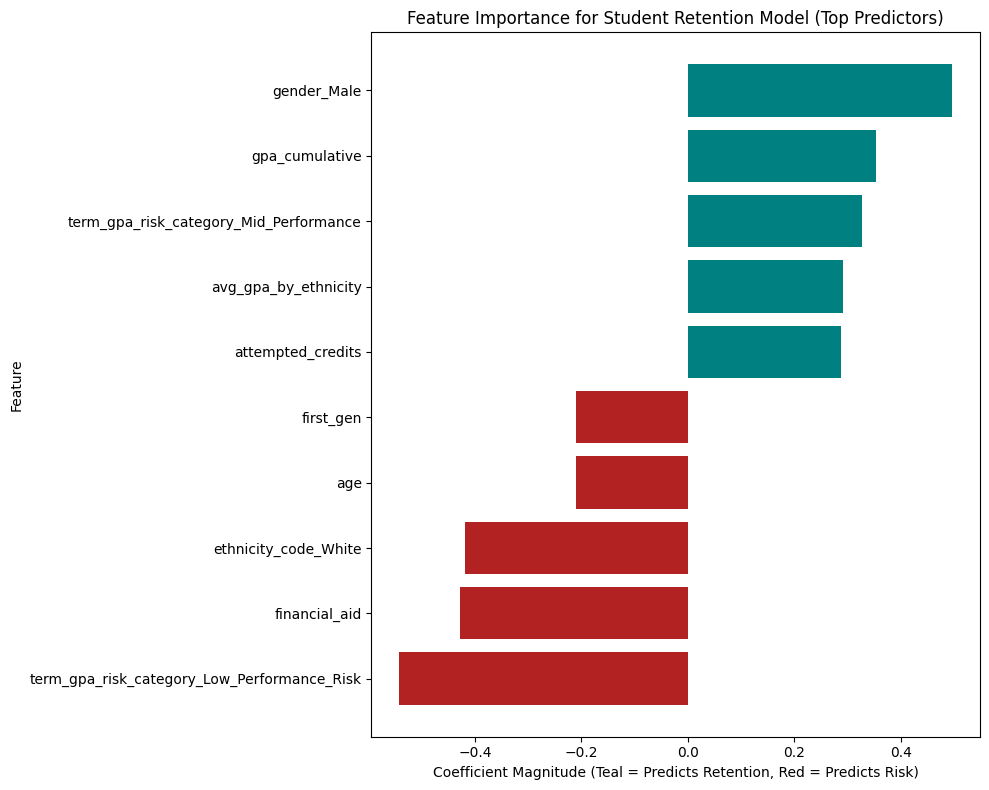

Step 6: Feature Importance Plot generated successfully.

--- Model Workflow Complete ---
New features (risk category, cohort average) successfully used in model.
Top 5 most impactful positive predictors (Retention):
gender_Male                               0.496454
gpa_cumulative                            0.353916
term_gpa_risk_category_Mid_Performance    0.327529
avg_gpa_by_ethnicity                      0.291726
attempted_credits                         0.288182
dtype: float64
Top 5 most impactful negative predictors (Risk/Dropout):
first_gen                                     -0.209637
age                                           -0.210861
ethnicity_code_White                          -0.417867
financial_aid                                 -0.428592
term_gpa_risk_category_Low_Performance_Risk   -0.542464
dtype: float64


In [1]:
# --------------------------------------------------------------------------------
# Student Proactive Risk Prediction Model: Complete Python Workflow
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# Step 1: Setup and Import Libraries
# --------------------------------------------------------------------------------

import pandas as pd
from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Suppress minor warnings for clean notebook output
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Libraries imported successfully.")

# --------------------------------------------------------------------------------
# Step 2: Database Connection and Data Ingestion
# --------------------------------------------------------------------------------

# 2.1 CONFIGURATION: *** REPLACE THESE WITH YOUR ACTUAL PGADMIN CREDENTIALS ***
# Note: Ensure DB_NAME matches the name used in your phAdmin setup.
DB_USER = "postgres" 
DB_PASS = "postgre_SQLacc0unt87"
DB_HOST = "localhost"   
DB_PORT = "5432"        
DB_NAME = "InstitutionalEffectiveness"

# Construct the SQLAlchemy connection string
db_url = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(db_url)

print(f"Attempting connection to {DB_NAME}...")

# 2.2 SQL Query: Defines the features (predictors) and the target variable (is_retained).
SQL_QUERY = """
WITH Joined_Data AS (
    -- Step 1: Combine data from the three distinct source tables (simulating ERP/RCM/etc. systems)
    SELECT
        s.student_id,
        s.cumulative_gpa,
        s.credit_hours_attempted,
        s.term_gpa,
        s.is_first_gen_student,
        s.age_at_enrollment,
        s.next_term_status,
        d.ethnicity_code,
        d.gender,
        f.received_financial_aid
    FROM
        student_academic_snapshot s
    LEFT JOIN
        student_demographics d ON s.student_id = d.student_id
    LEFT JOIN
        financial_aid_status f ON s.student_id = f.student_id
    WHERE
        s.term_code = '2024FA' 
        AND s.is_active = TRUE
)

-- Step 2: Perform feature engineering and select final columns
SELECT
    student_id,
    -- TARGET VARIABLE (1=retained, 0=not retained)
    CASE WHEN next_term_status = 'Enrolled' THEN 1 ELSE 0 END AS is_retained,
    
    -- PREDICTOR VARIABLES (Features)
    cumulative_gpa AS gpa_cumulative,
    credit_hours_attempted AS attempted_credits,
    is_first_gen_student AS first_gen,
    age_at_enrollment AS age,
    received_financial_aid AS financial_aid,
    ethnicity_code,
    gender,
    
    -- NEW ENGINEERED FEATURE 1: Conditional Logic (Risk Category)
    CASE
        WHEN term_gpa >= 3.50 THEN 'High_Performance'
        WHEN term_gpa >= 2.50 AND term_gpa < 3.50 THEN 'Mid_Performance'
        ELSE 'Low_Performance_Risk'
    END AS term_gpa_risk_category,

    -- NEW ENGINEERED FEATURE 2: Window Function (Cohort Metric)
    AVG(cumulative_gpa) OVER (PARTITION BY ethnicity_code) AS avg_gpa_by_ethnicity

FROM
    Joined_Data;
"""

# 2.3 Load Data: Executes the query and loads results into a Pandas DataFrame.
try:
    df = pd.read_sql(SQL_QUERY, engine)
    print(f"Step 2: Data successfully loaded (E/T). Shape: {df.shape}")
    print("New features 'term_gpa_risk_category' and 'avg_gpa_by_ethnicity' are now included.")
except Exception as e:
    print(f"CRITICAL ERROR IN STEP 2: Database connection or query failed. Check credentials/server status: {e}")
    exit() 

# --------------------------------------------------------------------------------
# Step 3: Data Cleansing and Preprocessing
# --------------------------------------------------------------------------------

# 3.1 Handling Missing Values
df['financial_aid'] = df['financial_aid'].fillna(0) 
df.dropna(subset=['ethnicity_code', 'gender', 'term_gpa_risk_category'], inplace=True) 
print(f"Step 3: Data cleaned. Shape after NA drop: {df.shape}")

# 3.2 Feature Engineering: Convert categorical text into numerical features (One-Hot Encoding)
df = pd.get_dummies(df, columns=['ethnicity_code', 'gender', 'term_gpa_risk_category'], drop_first=True)

# Define the final numerical feature matrix (X) and the target vector (y)
feature_cols = [col for col in df.columns if col not in ['student_id', 'is_retained']]
X = df[feature_cols]
y = df['is_retained']
print(f"Step 3.2: Features encoded. Total features for model: {len(X.columns)}")

# --------------------------------------------------------------------------------
# Step 4 & 5: Model Training and Evaluation
# --------------------------------------------------------------------------------

# 4.1 Split data (70% Train, 30% Test) to ensure unbiased evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4.2 Initialize and train the Logistic Regression Model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)
print("Step 4: Logistic Regression Model trained successfully.")

# 5.1 Evaluate Model Performance
y_prob = model.predict_proba(X_test)[:, 1] 
y_pred = model.predict(X_test)             

auc = roc_auc_score(y_test, y_prob)
print(f"Step 5: Model Evaluation Complete. AUC Score: {auc:.4f}")

# --------------------------------------------------------------------------------
# Step 6: Interpretation - Generating the Feature Importance Plot
# --------------------------------------------------------------------------------

# 6.1 Extract and sort coefficients
coefficients = model.coef_[0]
feature_names = X.columns
importance = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

# 6.2 Plot the Feature Importance (VISUAL FOR YOUR PORTFOLIO SCREENSHOT)
plt.figure(figsize=(10, 8))

# Select top 5 positive and top 5 negative features for a balanced view
top_n = 10
plot_importance = pd.concat([importance.head(top_n // 2), importance.tail(top_n // 2)])
plot_importance = plot_importance.sort_values(ascending=True)

# Assign colors: Teal for positive correlation (predicts retention), Red for negative (predicts risk)
colors = ['firebrick' if val < 0 else 'teal' for val in plot_importance.values]

plt.barh(plot_importance.index, plot_importance.values, color=colors)
plt.title('Feature Importance for Student Retention Model (Top Predictors)')
plt.xlabel('Coefficient Magnitude (Teal = Predicts Retention, Red = Predicts Risk)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show() 
print("Step 6: Feature Importance Plot generated successfully.")

# --------------------------------------------------------------------------------
# Step 7: Final Output and Conclusion
# --------------------------------------------------------------------------------

print("\n--- Model Workflow Complete ---")
print("New features (risk category, cohort average) successfully used in model.")
print(f"Top 5 most impactful positive predictors (Retention):\n{importance.head(5)}")
print(f"Top 5 most impactful negative predictors (Risk/Dropout):\n{importance.tail(5)}")